In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import os
import pathlib
import random as rn
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from sklearn.metrics import accuracy_score
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.test.gpu_device_name()

Num GPUs Available:  0


''

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_path = '/content/drive/MyDrive/DM ML dataset/Train'
test_path = '/content/drive/MyDrive/DM ML dataset/Test'
height = 50
width = 50

In [ ]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing' ,
            42:'End no passing veh > 3.5 tons' }

In [ ]:
batch_size = 150
seed = 42

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)
train_dataset = train_datagen.flow_from_directory(train_path,
                                                  target_size=(height, width),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  seed=seed,
                                                  color_mode='rgb',
                                                  interpolation='hamming',
                                                  subset='training')

test_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split=0.2)
test_dataset = test_datagen.flow_from_directory(train_path,
                                                target_size=(height, width),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True,
                                                seed=seed,
                                                color_mode='rgb',
                                                interpolation='hamming',
                                                subset='validation')


Found 25713 images belonging to 43 classes.
Found 6425 images belonging to 43 classes.


In [ ]:
vgg_model = tf.keras.Sequential([VGG19(weights='imagenet', include_top=False, input_shape=(height,width,3)),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Flatten(),
                                 keras.layers.Dense(512, activation='sigmoid'),
                                 keras.layers.Dense(43, activation='softmax')
                                ])

vgg_model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 batch_normalization (BatchN  (None, 1, 1, 512)        2048      
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 43)                22059     
                                                                 
Total params: 20,311,147
Trainable params: 20,310,123
Non

In [ ]:
alpha=0.001
epochs=5
optim = keras.optimizers.Adam(learning_rate=alpha)
vgg_model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [ ]:
vgg_history = vgg_model.fit(train_dataset,
                        steps_per_epoch=len(train_dataset),
                        epochs=epochs,
                        validation_data=test_dataset,
                        validation_steps=len(test_dataset))

Epoch 1/5
172/172 [==============================] - 7376s 43s/step - loss: 2.5872 - accuracy: 0.2303 - val_loss: 2.2221 - val_accuracy: 0.3074
Epoch 2/5
172/172 [==============================] - 4735s 28s/step - loss: 1.3050 - accuracy: 0.5874 - val_loss: 4.5048 - val_accuracy: 0.1317
Epoch 3/5
172/172 [==============================] - 4670s 27s/step - loss: 0.7461 - accuracy: 0.7686 - val_loss: 4.6854 - val_accuracy: 0.1292
Epoch 4/5
172/172 [==============================] - 4643s 27s/step - loss: 0.4381 - accuracy: 0.8648 - val_loss: 1.8894 - val_accuracy: 0.4148
Epoch 5/5
172/172 [==============================] - 4641s 27s/step - loss: 0.2738 - accuracy: 0.9204 - val_loss: 0.4093 - val_accuracy: 0.8724


In [ ]:
vgg_model.save("VGG.h5")

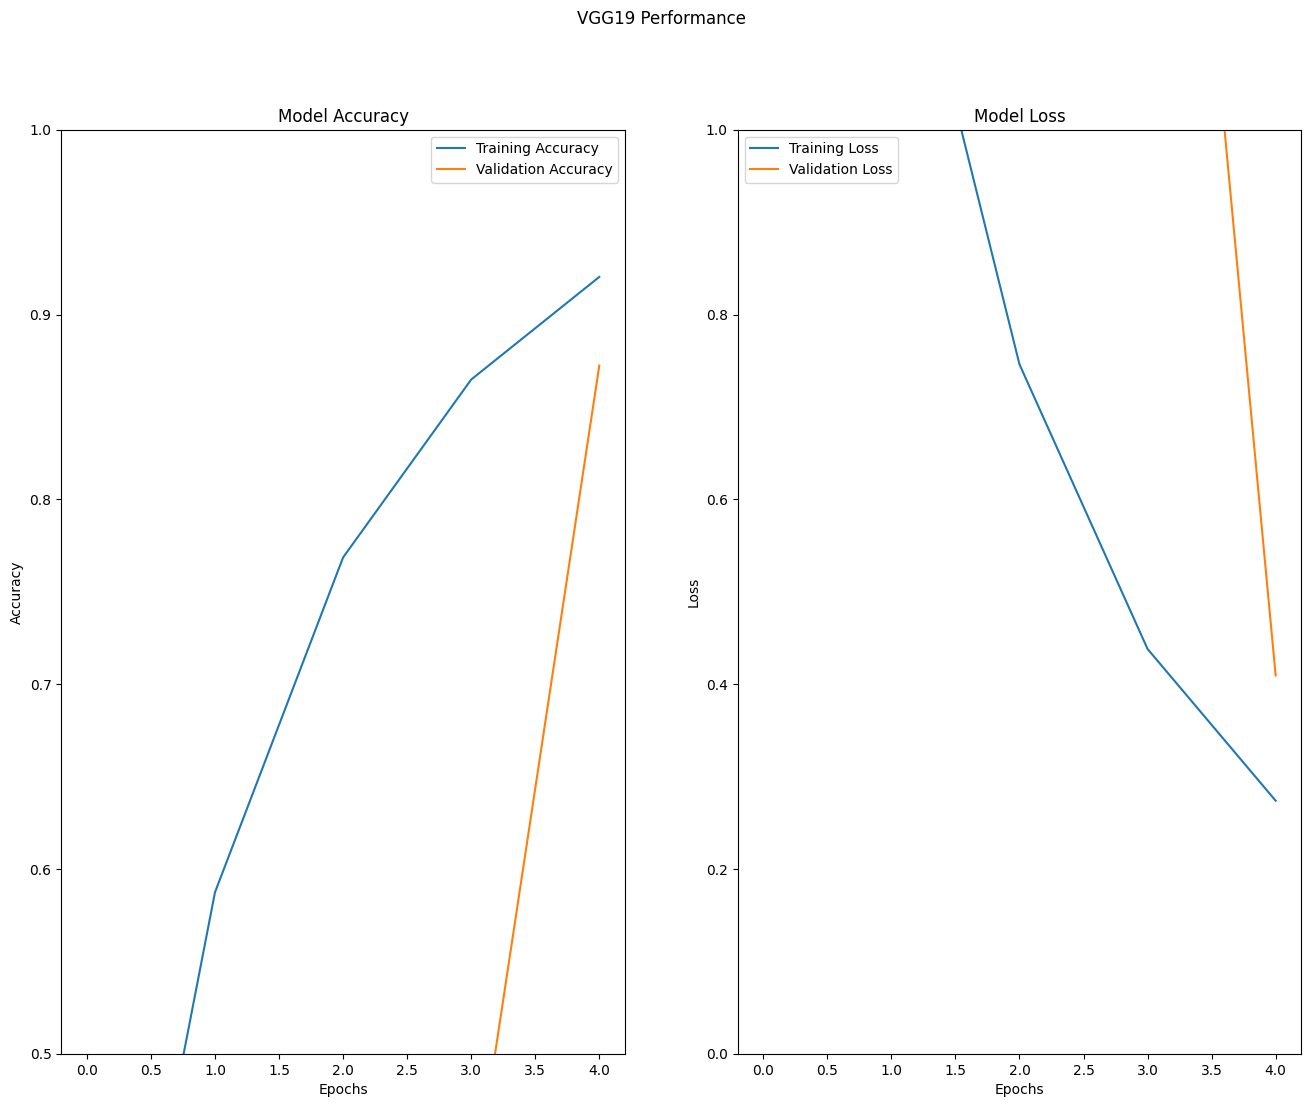

<Figure size 1000x700 with 0 Axes>

In [ ]:
fig,ax=plt.subplots(1,2)
fig.set_size_inches(16,12)
performance = pd.DataFrame(vgg_history.history)
plt.figure(figsize=(10,7))
ax[1].plot(performance[['loss','val_loss']])
ax[1].legend(['Training Loss', 'Validation Loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_ylim(0,1)
ax[0].plot(performance[['accuracy','val_accuracy']])
ax[0].legend(['Training Accuracy', 'Validation Accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0.5,1)
fig.suptitle('VGG19 Performance')
plt.show()
